Find the markdown blocks that say interaction required! The notebook should take care of the rest!

# Import libs

In [1]:
import sys
import os
sys.path.append('..')
from eflow.foundation import DataPipeline
from eflow.foundation import DataFrameTypes
from eflow.data_analysis import FeatureAnalysis
from eflow.data_analysis import NullAnalysis
from eflow.model_analysis import ClassificationAnalysis
from eflow.data_pipeline_segments import DataTransformer
from eflow.data_pipeline_segments import TypeFixer
from eflow.utils.modeling_utils import optimize_model_grid
from eflow.utils.eflow_utils import get_type_holder_from_pipeline
from eflow.utils.math_utils import get_unbalanced_threshold
from eflow.utils.eflow_utils import remove_unconnected_pipeline_segments
from eflow.utils.sys_utils import create_dir_structure
from eflow.utils.eflow_utils import create_color_dict_for_features
from eflow.utils.pandas_utils import data_types_table, value_counts_table, suggest_removal_features 

import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import copy
from IPython.display import clear_output
from IPython.core.getipython import get_ipython
import ipython_blocking
import nltk

In [2]:
# # Additional add ons
# !pip install pandasgui
# !pip install pivottablejs
# clear_output()

In [3]:
%matplotlib notebook
%matplotlib inline

## Juypter notebook generating cells

### Important Note: Replace if set to True will remove all the contents of whatever cell it is called in. But it can be undone with a simple CMD + Z. 🙂

In [4]:
# Author: http://tinyurl.com/y6mghyzl
def create_new_cell(contents,
                    replace=False):
    shell = get_ipython()
    shell.set_next_input(contents,
                         replace=replace)

def __format_list_to_string(list_name,
                            list_contents):
    output_str = f"{list_name} = ["
    escape_seq_count = 0
    final_index = len(list_contents) - 1
    req_spacing = len(output_str)

    for i,element in enumerate(list_contents):
        if i == final_index:
            output_str += f'\"{element}\"'
        else:
            output_str += f'\"{element}\",'
        
        if len(output_str.split("\n")[escape_seq_count]) > 78:
            output_str += "\n"
            output_str += (" " * req_spacing)
            escape_seq_count += 1
    output_str += "]"
    return output_str
        
# Jupyter block filled with removal features.
def create_new_cell_with_removal_features(df,
                                          replace=True):
    """
    df:
        Pandas DataFrame object
    Returns/Desc:
        Creates a new cell block in the same block
    """
    
    # Get suggestions for removal
    cell_content = __format_list_to_string("removal_features",
                                           suggest_removal_features(df))
    # Add a sort of calling card of the function that created it
    cell_content = f"# create_new_cell_with_removal_features(df,replace={replace})\n" + cell_content
    create_new_cell(cell_content,
                    replace=replace)

# Jupyter block filled with features that exceed a certain percentange of nulls
def create_new_cell_with_null_removal_features(df,
                                               null_threshold=.25,
                                               replace=True):
    
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum() / len(df)

    cell_content = __format_list_to_string("remove_null_features",
                                            mis_val_percent[mis_val_percent > null_threshold].index.to_list())
    # Add a sort of calling card of the function that created it
    cell_content += f"# create_new_cell_with_null_removal_features(df,null_threshold={null_threshold},replace={replace})\n"
    create_new_cell(cell_content,
                    replace=replace)

# Jupyer block filled with feature values to proper colors
def create_new_cell_with_feature_value_color_dict(df,
                                                  df_features,
                                                  replace=True):
    feature_value_color_dict = create_color_dict_for_features(df,
                                                              df_features)
    # Add a sort of calling card of the function that created it
    cell_content = ""
    cell_content += f"# create_new_cell_with_feature_value_color_dict(df,df_features,replace={replace})\n"
    cell_content += "feature_value_color_dict=dict()"
    
    for feature_name, feature_value_color in feature_value_color_dict.items():
        for feature_value, color in feature_value_color.items():
            color = feature_value_color_dict[feature_name][feature_value]
            cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][\"{feature_value}\"] = \"{color}\""
            create_new_cell(cell_content,
                        replace=replace)

## Declare Project Variables

### Interaction required

In [5]:
dataset_path = "Datasets/titanic_train.csv"

# -----
dataset_name = "Titanic Data"
pipeline_name = "Titanic Pipeline"

# -----
pre_processing_name = f"{dataset_name}/Before Cleaning"
post_processing_name = f"{dataset_name}/Cleaned data"

# -----
notebook_mode = True

## Clean out segment space

In [6]:
remove_unconnected_pipeline_segments()

# Import dataset

In [7]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

,Rows,Columns
0,891,12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Throwing in garbage data for testing purposes only!!!

In [8]:
# df["Sex"][0] = np.nan
# df["Survived"] = df["Survived"].astype("object")
# df["Age"] = df["Age"].astype('object')
# df["Age"][33] = "      "
# df["Pclass"][50] = "2sdf,asdqw"
# df["SibSp"][2] = np.nan

In [9]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
PassengerId,int64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Name,object
Sex,object


## Gui tools for quick analysis dataframes

Great interface; pauses the program; comment on/off at free will.
You will need to reset kernel after use more than likely.

In [10]:
# from pandasgui import show as qt_display
# qt_display(df)
# %matplotlib inline

In [11]:
# pivot_ui(df,
#          outfile_path='Piviot_Table_JS.html')

## Skim through Value Counts

In [12]:
for feature_name in df.columns:
    print(f'******* Feature: {feature_name} *******')
    print(f'Type: {df[feature_name].dtype}')
    display(value_counts_table(df,
                               feature_name))
    print("-------" * 4 + "\n\n")

******* Feature: PassengerId *******
Type: int64


,Counts,Percantage
Unique Values,,
891,1,0.1122%
293,1,0.1122%
304,1,0.1122%
303,1,0.1122%
302,1,0.1122%
...,...,...
591,1,0.1122%
590,1,0.1122%
589,1,0.1122%


----------------------------


******* Feature: Survived *******
Type: int64


,Counts,Percantage
Unique Values,,
0,549,61.6162%
1,342,38.3838%


----------------------------


******* Feature: Pclass *******
Type: int64


,Counts,Percantage
Unique Values,,
3,491,55.1066%
1,216,24.2424%
2,184,20.6510%


----------------------------


******* Feature: Name *******
Type: object


,Counts,Percantage
Unique Values,,
"Pavlovic, Mr. Stefo",1,0.1122%
"Navratil, Mr. Michel (""Louis M Hoffman"")",1,0.1122%
"Jarvis, Mr. John Denzil",1,0.1122%
"Jacobsohn, Mr. Sidney Samuel",1,0.1122%
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.1122%
...,...,...
"Perkin, Mr. John Henry",1,0.1122%
"Fortune, Miss. Mabel Helen",1,0.1122%
"Emanuel, Miss. Virginia Ethel",1,0.1122%


----------------------------


******* Feature: Sex *******
Type: object


,Counts,Percantage
Unique Values,,
male,577,64.7587%
female,314,35.2413%


----------------------------


******* Feature: Age *******
Type: float64


,Counts,Percantage
Unique Values,,
24.00,30,3.3670%
22.00,27,3.0303%
18.00,26,2.9181%
19.00,25,2.8058%
30.00,25,2.8058%
...,...,...
55.50,1,0.1122%
70.50,1,0.1122%
66.00,1,0.1122%


----------------------------


******* Feature: SibSp *******
Type: int64


,Counts,Percantage
Unique Values,,
0,608,68.2379%
1,209,23.4568%
2,28,3.1425%
4,18,2.0202%
3,16,1.7957%
8,7,0.7856%
5,5,0.5612%


----------------------------


******* Feature: Parch *******
Type: int64


,Counts,Percantage
Unique Values,,
0,678,76.0943%
1,118,13.2435%
2,80,8.9787%
5,5,0.5612%
3,5,0.5612%
4,4,0.4489%
6,1,0.1122%


----------------------------


******* Feature: Ticket *******
Type: object


,Counts,Percantage
Unique Values,,
CA. 2343,7,0.7856%
1601,7,0.7856%
347082,7,0.7856%
3101295,6,0.6734%
CA 2144,6,0.6734%
...,...,...
2695,1,0.1122%
A.5. 18509,1,0.1122%
PC 17612,1,0.1122%


----------------------------


******* Feature: Fare *******
Type: float64


,Counts,Percantage
Unique Values,,
8.0500,43,4.8260%
13.0000,42,4.7138%
7.8958,38,4.2649%
7.7500,34,3.8159%
26.0000,31,3.4792%
...,...,...
8.4583,1,0.1122%
9.8375,1,0.1122%
8.3625,1,0.1122%


----------------------------


******* Feature: Cabin *******
Type: object


,Counts,Percantage
Unique Values,,
G6,4,0.4489%
C23 C25 C27,4,0.4489%
B96 B98,4,0.4489%
F33,3,0.3367%
D,3,0.3367%
...,...,...
E63,1,0.1122%
C118,1,0.1122%
F38,1,0.1122%


----------------------------


******* Feature: Embarked *******
Type: object


,Counts,Percantage
Unique Values,,
S,644,72.2783%
C,168,18.8552%
Q,77,8.6420%


----------------------------




# Mark target feature; set to None if not needed

### Interaction required

### Supervised learning problems (Can be set to None)

In [13]:
target_feature = "Survived"

In [14]:
try:
    if target_feature:
        df[target_feature]
except KeyError:
    raise KeyError(f"The target feature \'{target_feature}\' was not found in the dataframe!"
                   + " Please select a valid feature from the dataframe")

In [15]:
if target_feature:
    print(f"Target feature '{target_feature}'")
    print("----" * 10)
    target_amount = len(df[target_feature].dropna().value_counts().index)
    value_count_df = value_counts_table(df,
                                        target_feature)
    if target_amount < 1:
        display(value_count_df)
    else:
        max_unbalanced_class_threshold, min_unbalanced_class_threshold = get_unbalanced_threshold(target_amount)
        print(f"max_unbalanced_class_threshold = {max_unbalanced_class_threshold * 100:.3f}%")
        print(f"min_unbalanced_class_threshold = {min_unbalanced_class_threshold * 100:.3f}%")
        display(value_count_df)
        index = 0
        for percentage in value_count_df["Percantage"]:
            percentage = float(percentage[:-1])/100
            if percentage >= max_unbalanced_class_threshold or percentage <= min_unbalanced_class_threshold:
                print(f"The value '{value_count_df.index.values[index]}' is causing the target feature to be unbalanced.\n" +
                      "This could cause a model to not properly generalize itself.")
                print("---" * 10 + "\n")

            index += 1

Target feature 'Survived'
----------------------------------------
max_unbalanced_class_threshold = 65.000%
min_unbalanced_class_threshold = 35.000%


,Counts,Percantage
Unique Values,,
0,549,61.6162%
1,342,38.3838%


# Load/Init DataFrameTypes object.

This object is used to store an abstracted form of what a feature 'should be' rather than what the pandas dataframe object says it is. In this case we will be specifying all features correct types.

Comment out/remove depending on how you want your design flow to be.

In [16]:
# df_features = DataFrameTypes(df,
#                              ignore_nulls=True,
#                              fix_numeric_features=True,
#                              fix_string_features=True,
#                              target_feature=target_feature,
#                              notebook_mode=notebook_mode)

## Make any changes to 'df_features' that automated type assertions messed up.

Ex: Sometimes df_features will think a feature is a category when it isn't. Move to proper.

In [17]:
# df_features.set_feature_to_bool(feature_name=[])
# df_features.set_feature_to_integer(feature_name=[])
# df_features.set_feature_to_float(feature_name=[])
# df_features.set_feature_to_string(feature_name=[])
# df_features.set_feature_to_datetime(feature_name=[])
# df_features.set_feature_to_categorical(feature_name=[])

## Creates a json file of df_features

In [18]:
# df_features.create_json_file_representation(os.getcwd(),
#                                             "df_features.json")

## Loading back df_features (giving both ways you can load them in)

In [19]:
# Option: 1
# df_features = get_type_holder_from_pipeline(pipeline_name)

In [20]:
# Option: 2
df_features = DataFrameTypes(df=None)
df_features.init_on_json_file(os.getcwd() + "/df_features.json")

In [21]:
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

,Data Types
Features,
Sex,string
Embarked,string
Name,string
Cabin,string
Ticket,string
Survived,bool
SibSp,integer
Parch,integer
Age,float


In [22]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Setup pipeline structure

### Interaction Required

In [23]:
main_pipe = DataPipeline(pipeline_name,
                         df_features,
                         remove_past_contents=True)

The file 'root_pipeline.json' exist!
Moving past contents to eFlow's garbage.


## Remove any unwanted features for the pipeline

### Interaction required

Note: When starting the project uncomment the function to get suggestions and then run the cell again

In [24]:
# create_new_cell_with_removal_features(df,replace=True)
removal_features = ["PassengerId","Ticket","Name"]

In [25]:
if len(removal_features):
    data_transformer = DataTransformer()
    data_transformer.remove_features(df,
                                     df_features,
                                     removal_features)
    main_pipe.add("Remove Unwanted Features",
                  data_transformer)

In [26]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Sex,object
Cabin,object
Embarked,object


## Interaction Required

### Make any required type assertions that the program missed

# Analysis of null data

In [27]:
# null_analysis = NullAnalysis(project_sub_dir=pre_processing_name,
#                              notebook_mode=notebook_mode)

# null_analysis.perform_analysis(df,
#                                dataset_name=dataset_name,
#                                null_features_only=True)

# del null_analysis

## Remove Unwanted Columns due to illogical nulls

### Interaction required

### Any features that have to many nulls/we can't or shouldn't perform any special logic to determine the closest or actual value

In [28]:
# create_new_cell_with_null_removal_features(df,null_threshold=0.25,replace=True)
remove_null_features = ["Cabin"]

### Add to main pipeline

In [29]:
if len(remove_null_features):
    data_transformer = DataTransformer()
    data_transformer.remove_features(df,
                                     df_features,
                                     remove_null_features)
    main_pipe.add("Remove unresolvable null features",
                  data_transformer)

    del data_transformer

Pie graph for distance plot graph on Survived


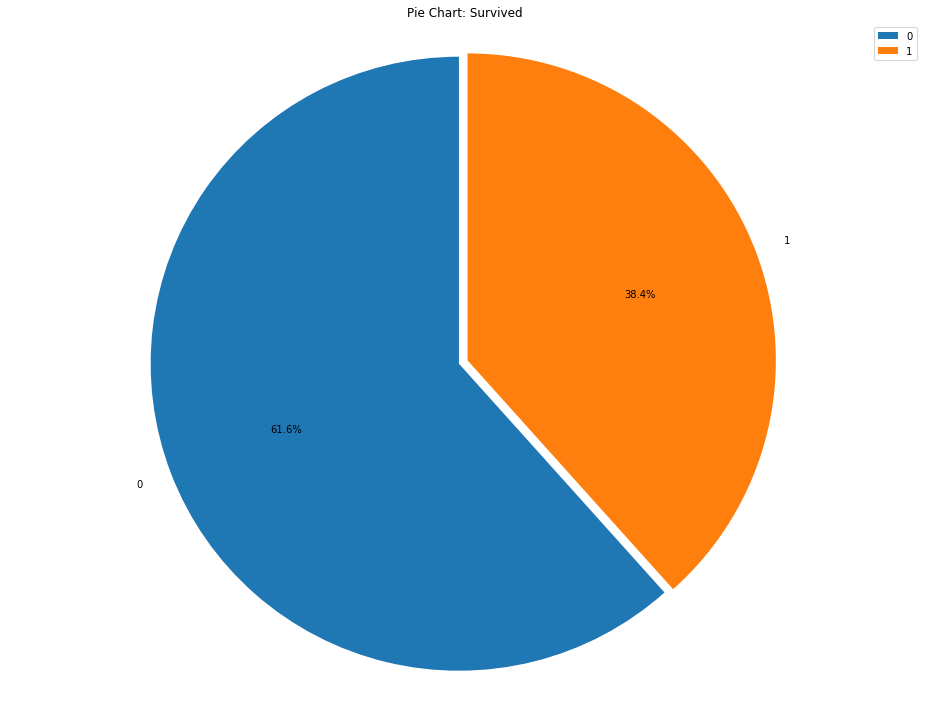

Rank count plot graph for count plot on Survived


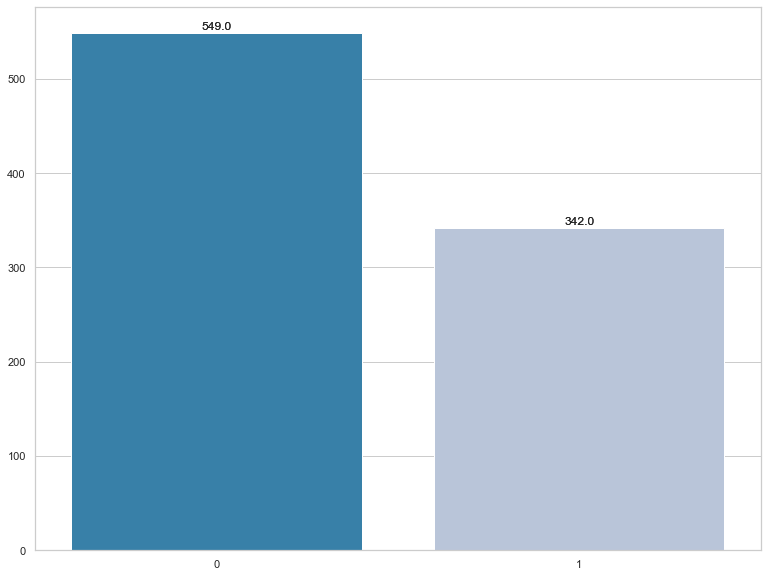

Pie graph for distance plot graph on Pclass


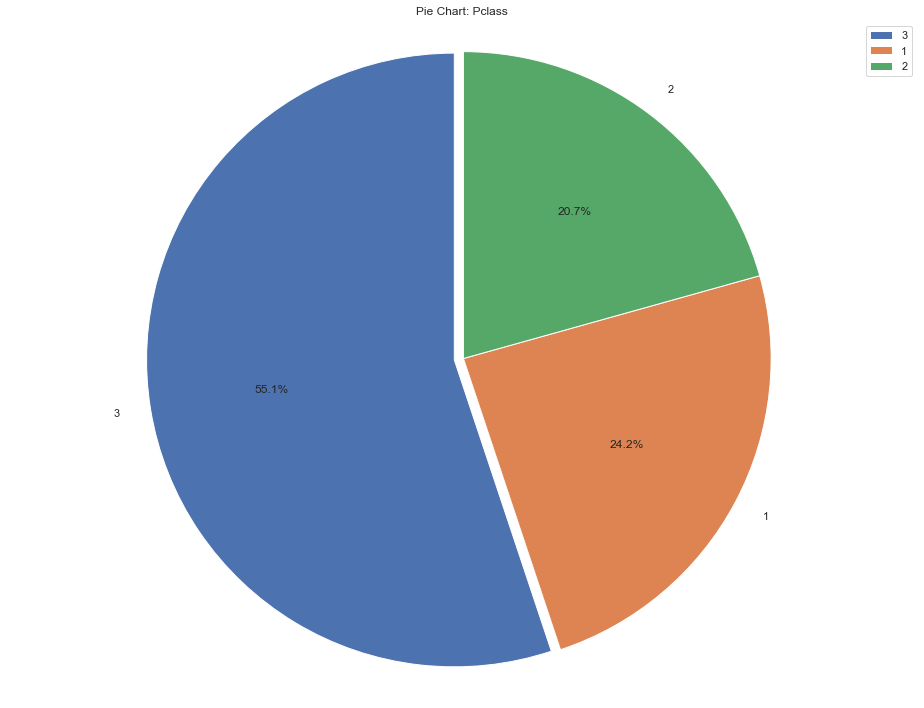

Rank count plot graph for count plot on Pclass


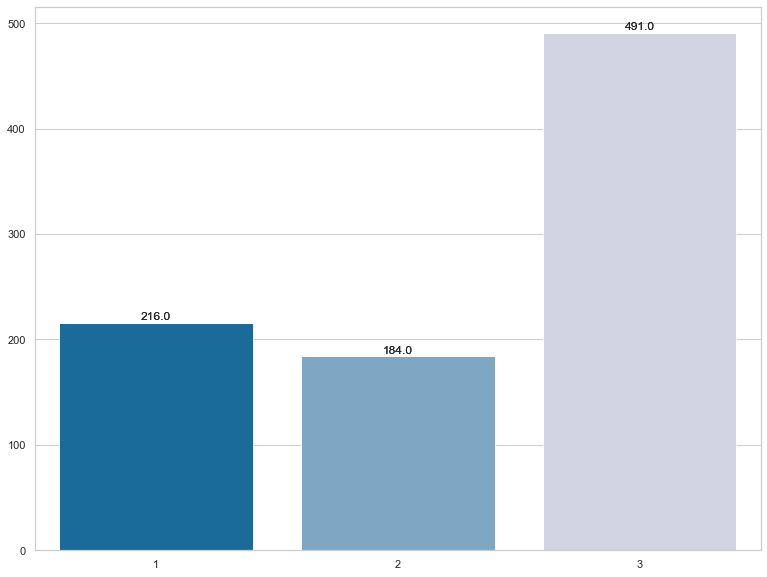

Pie graph for distance plot graph on Sex


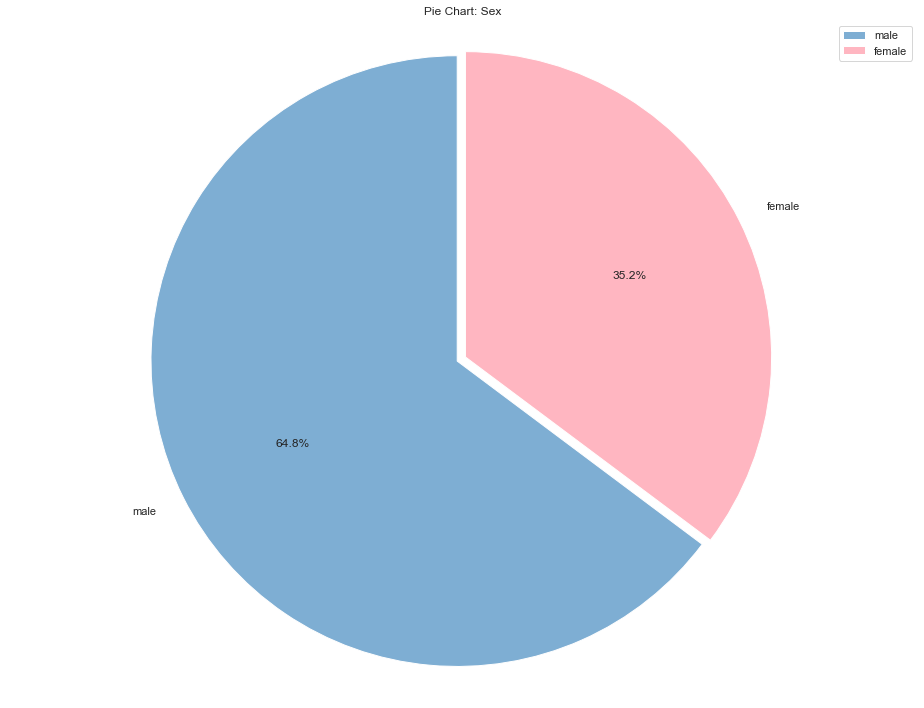

Rank count plot graph for count plot on Sex


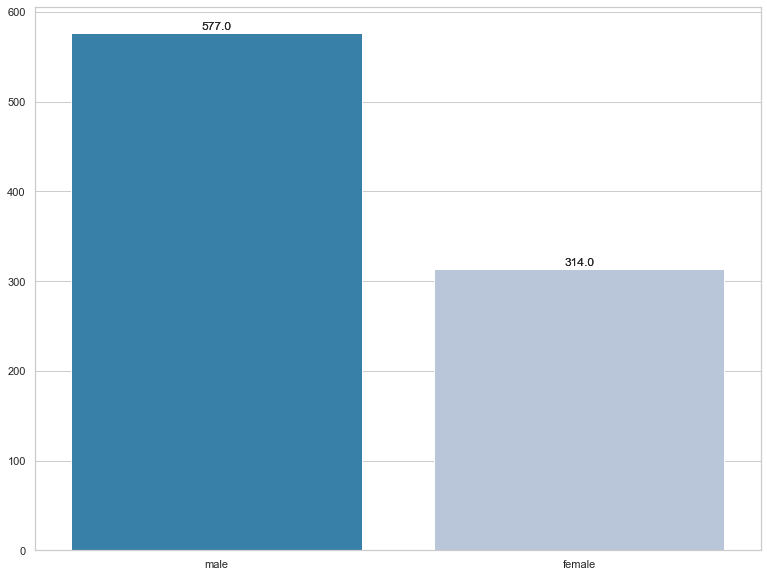

Generating graph for distance plot on Age


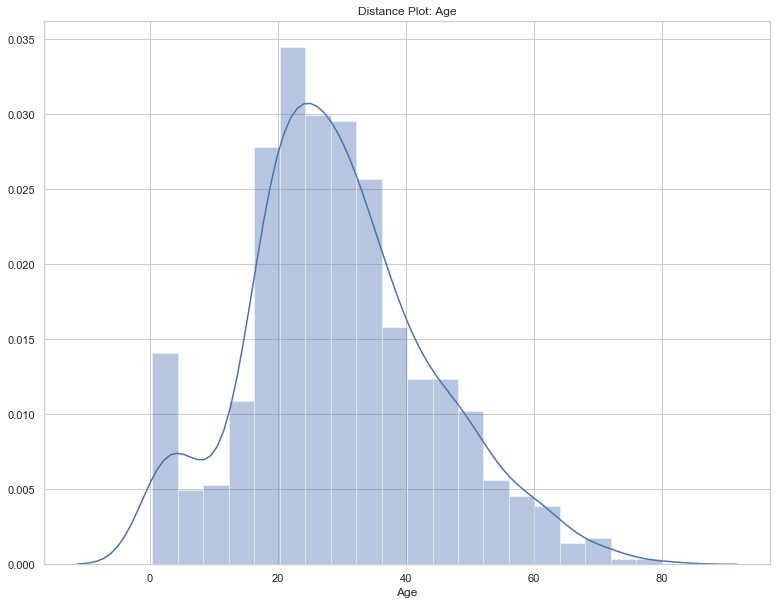

Generating graph violin graph on Survived by Age


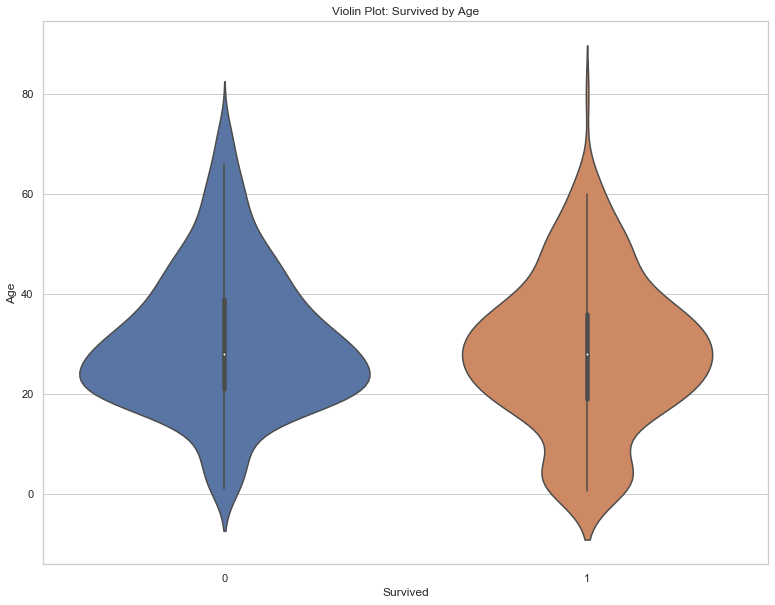

Generating graph for distance plot on SibSp


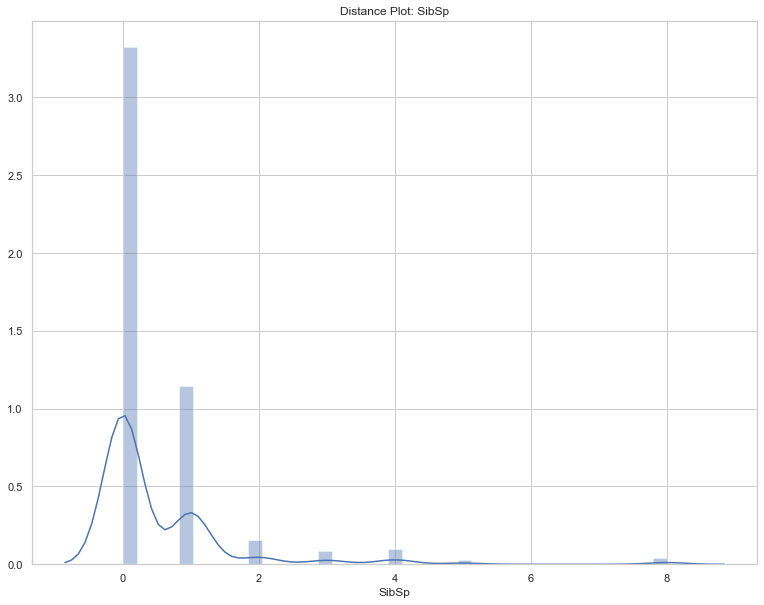

Generating graph violin graph on Survived by SibSp


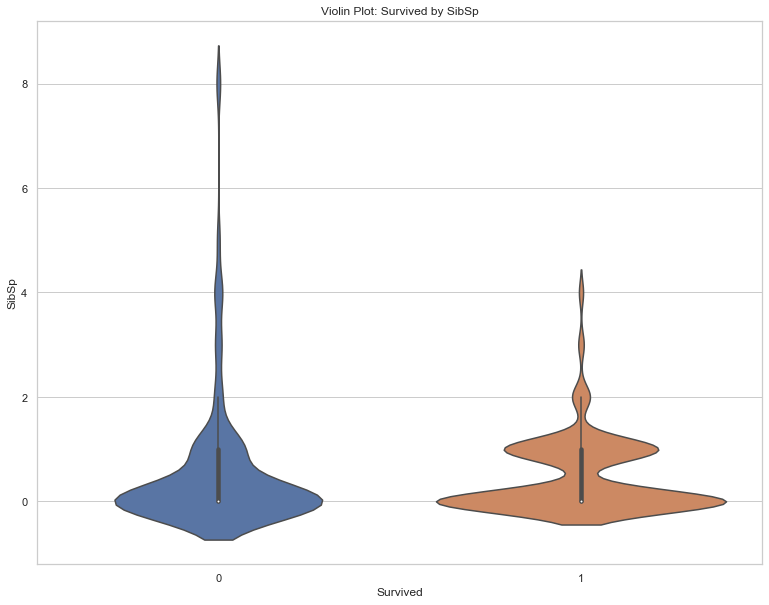

Generating graph for distance plot on Parch


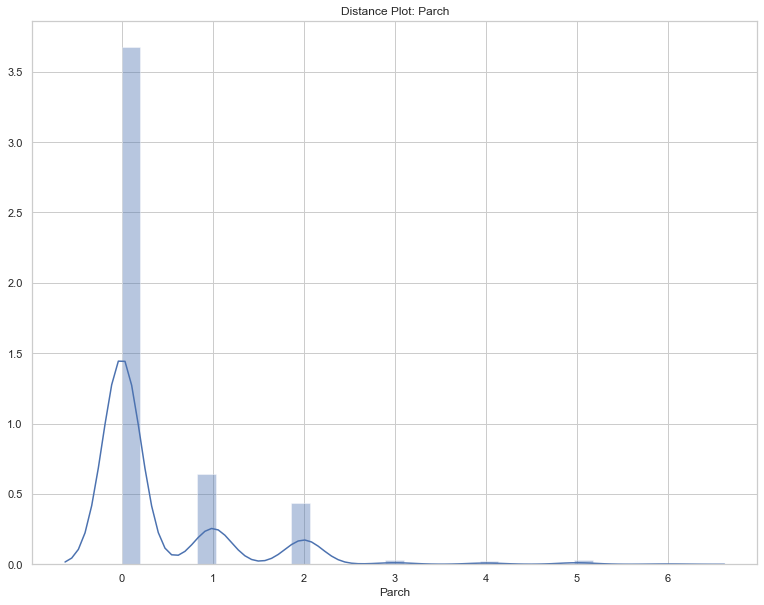

Generating graph violin graph on Survived by Parch


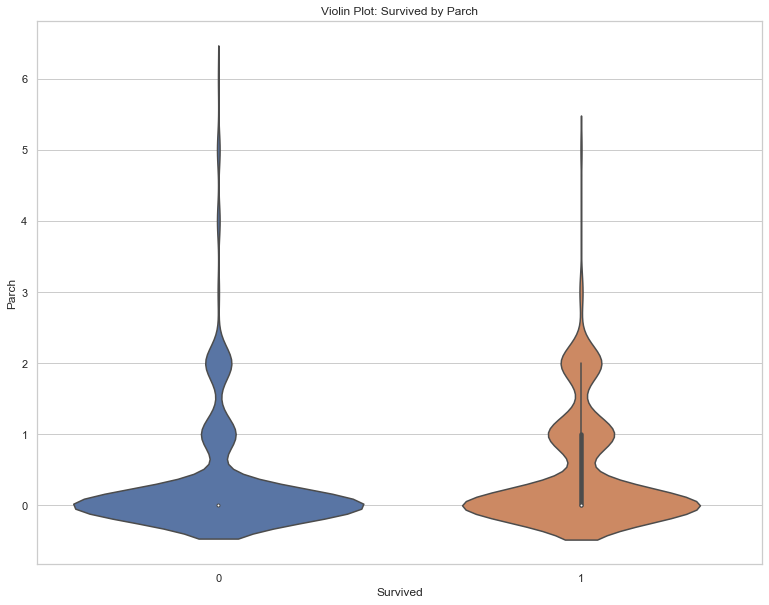

Generating graph for distance plot on Fare


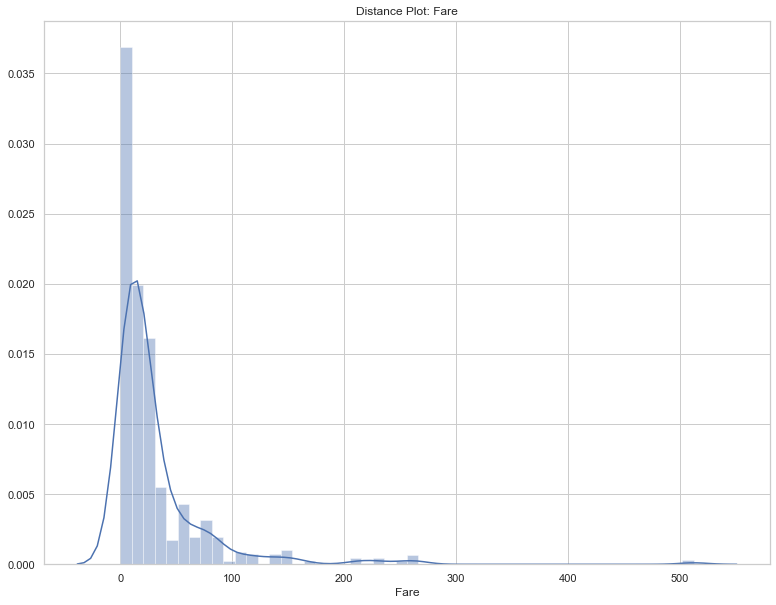

Generating graph violin graph on Survived by Fare


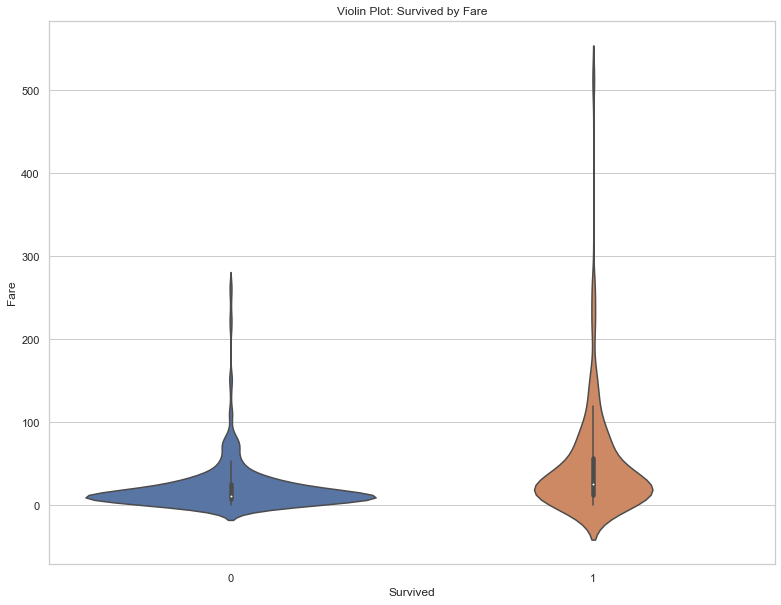

Pie graph for distance plot graph on Embarked


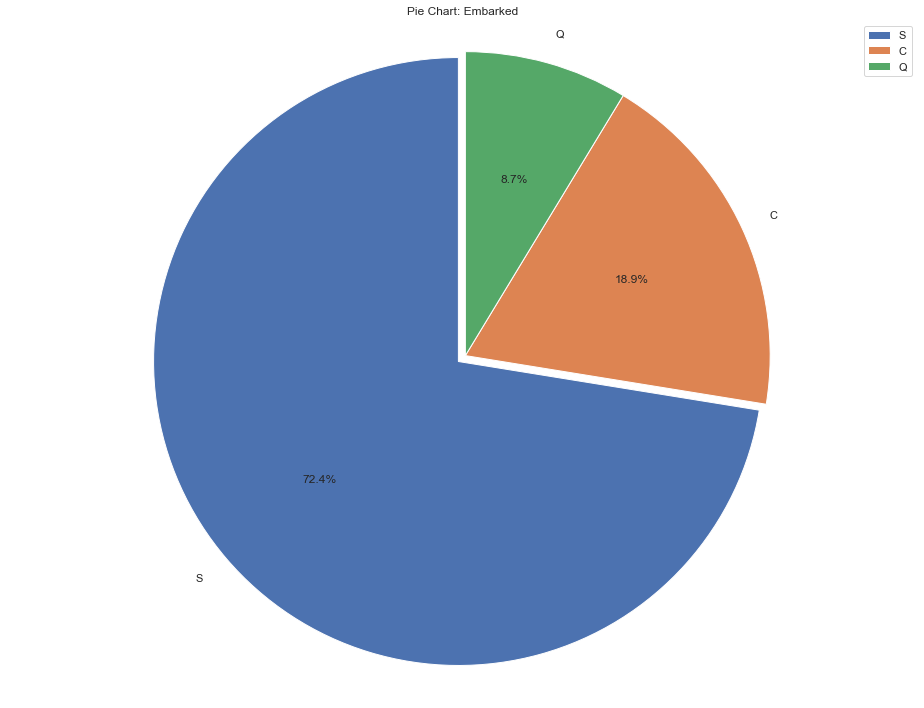

Rank count plot graph for count plot on Embarked


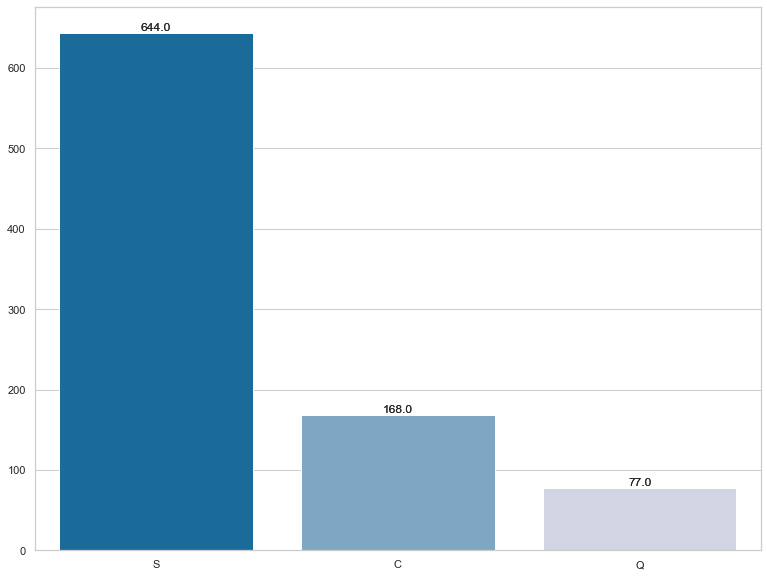

NameError: name 'SomeBullshit' is not defined

In [30]:
feature_analysis = FeatureAnalysis(project_sub_dir=pre_processing_name)
feature_analysis.perform_analysis(df,
                                  df_features,
                                  dataset_name=dataset_name)
del feature_analysis
raise SomeBullshit

0

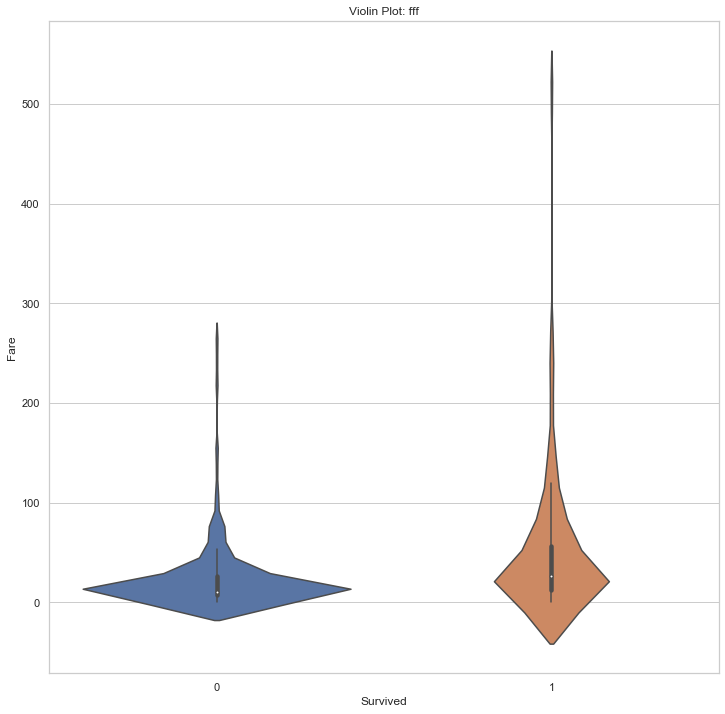

In [50]:
import seaborn as sns
plt.close()
plt.figure(figsize=(12,12))
plt.title("Violin Plot: " + "fff")
sns.violinplot(x=df[target_feature].dropna(),
               y=df["Fare"].dropna(),
               bw="scott")
sum(df["SibSp"] < 0)

In [ ]:
import struct

# def hex_to_rgb(hex_string):
    
#     hex_string = hex_string.replace("#","")
#     return struct.unpack('BBB', hex_string.decode('hex'))
# print(hex_to_rgb("#334455"))
plt.close()
iris_df = sns.load_dataset('iris')
 
# Make a dictionary with one specific color per group:
my_pal = {0: "g", 1: "b"}
 
#plot it
sns.violinplot(data=df, x=target_feature, y="Age", palette=my_pal)

# String Cleaning

# Data Type Changes

### Change data to proper types

### Look at data types

In [ ]:
data_types_table(df)

### Make given data type changes

### Looking at our type data before any null or value cleaning

In [ ]:
df_features.display_features(display_dataframes=False,
                             notebook_mode=True)

In [ ]:
data_types_table(df)

In [ ]:
import seaborn as sns
i = 0
colors = ["b", "g", "y", "black"]
plt.close()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
for target_val in df[target_feature].dropna().value_counts().index:
    sns.distplot(df["Age"].dropna()[df[target_feature].dropna() == target_val], color=colors[i])
    i += 1
plt.show()

plt.close()

plt.figure(figsize=(12, 8))
sns.barplot(
            df[target_feature],
            df["Pclass"],
            label="Total",
            color="b")
plt.close()

plt.figure(figsize=(12, 8))
sns.jointplot(df["Fare"],df["Age"], color=colors[i])
plt.show()
plt.close()

plt.figure(figsize=(12, 8))
# Show each distribution with both violins and points
sns.violinplot(df[target_feature], df["Age"], inner="points")
plt.show()
plt.close()


sns.pairplot(df[[feature_name for feature_name in df.columns if feature_name not in df_features.get_string_features()]], hue=f"{target_feature}", diag_kind='hist')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.20, light=.7)
g = sns.FacetGrid(df,
                  row=target_feature,
                  hue=target_feature,
                  aspect=15,
                  height=.4,
                  palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot,
      "Age",
      clip_on=False,
      shade=True,
      alpha=1,
      lw=1.5,
      bw=.2)
g.map(sns.kdeplot,
      "Age",
      clip_on=False,
      color="w",
      lw=2,
      bw=.2)

g.map(plt.axhline,
      y=0,
      lw=2,
      clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2,
            label,
            fontweight="bold",
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes)


g.map(label, "Age")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.set_size_inches(10, 10, forward=True)
g.fig.suptitle(f'{target_feature} by Age')

# Analysis of feature data

In [ ]:
feature_analysis = FeatureAnalysis(project_sub_dir=pre_processing_name)
feature_analysis.perform_analysis(df,
                                  df_features,
                                  dataset_name=dataset_name)
del feature_analysis

### Begin testing

### Final look at data types

In [ ]:
df_features.get_non_numerical_features()

## Data Cleaning

In [ ]:
# from impyute.imputation.cs import mice

# a = df["Age"].tolist()
# # start the MICE training
# imputed_training=mice(df.values)

In [ ]:
# import datawig

# df_train, df_test = datawig.utils.random_split(df)

# #Initialize a SimpleImputer model
# imputer = datawig.SimpleImputer(
#     input_columns=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin','Embarked'], # column(s) containing information about the column we want to impute
#     output_column= 'Age', # the column we'd like to impute values for
#     output_path = 'imputer_model' # stores model data and metrics
#     )

# #Fit an imputer model on the train data
# imputer.fit(train_df=df, num_epochs=200)

In [ ]:
# imputed_training=mice(df[df_features.get_numerical_features()].values)

In [ ]:
import random

test = copy.deepcopy(df)
test = test.dropna(axis='columns')
test["Sex"] = df["Sex"] == "female"
y = test[target_feature].values
X = test.drop(columns=[target_feature]).values

print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.80, random_state=517, stratify=y,
)

In [ ]:
display(set(y_train))
set(y_test)

In [ ]:
# Find best parameters for model
param_grid = {
    "max_depth": list(range(1, 4)),
#     "min_samples_leaf": list(range(80, 130, 5)),
#     "criterion": ["gini", "entropy"],
#     "n_splits": [20, 30]
}

model, best_params = optimize_model_grid(
    model=DecisionTreeClassifier(),
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    scoring="f1_micro"
)

In [ ]:
dt_model_analysis = ClassificationAnalysis(model=model,
                                           model_name=repr(model).split("(")[0],
                                           target_feature=target_feature,
                                           pred_funcs_dict={"Probabilities function":model.predict_proba,
                                                            "Predict function":model.predict},
                                           sample_data=X_train[0],
                                           project_sub_dir=f'{post_processing_name}/Classification Analysis',
                                           notebook_mode=notebook_mode,
                                           df_features=df_features)

In [ ]:
dt_model_analysis.perform_analysis(X=X_train,
                                   y=y_train,
                                   dataset_name="Train Data",
                                   thresholds_matrix=[[.0,.0],])

In [ ]:
dt_model_analysis.perform_analysis(X=X_test,
                                   y=y_test,
                                   dataset_name="Test Data",
                                   thresholds_matrix=[[.0,.0],])

In [ ]:
from eflow._hidden.utils.meta_data_identity import check_create_metadata_of_dataframe
testing_path = "/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eflow Data/Pre processing/Missing Data/All Data"
check_create_metadata_of_dataframe(df,
                                   testing_path)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, model.predict(X_test), average='micro')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model.predict(X_test), normalize=True)